In [1]:
import matplotlib.pyplot as plt
import numpy as np

## The 9x9 neighborhood
We make the (admittedly naive and limiting) assumptions that  
1. what matters for the primary estimation of a position's value is determined by the 9x9 neighborhood of that field, and
2. fields that don't share a common line (x, y, or diagonal) with the given position, don't matter either.

Farther fields simply won't directly contribute to a common line of length 5 or smaller.

Class ```N9x9``` (*Enn-nine-by-nine*) describes the world from the point of view of a particular position. This *pos-o-centric* view can be regarded as the relevant environment represented in polar-coordinates. It is much more meaningful to a neural network (I hope) than the cartesion representation. It allows us to devise a 64-bit representation of the current *threat* or *opportunity* created for a position by the adjacent stones.
- ```def register(self, color=c, direction=d, distance=s) ``` tells the class that there is a stone of color $c$ in direction $d$ with distance $s$

In [2]:
class GomokuTools:
    
    @staticmethod
    def dirs():
        return {
            'e' : (0, [0, 1]),
            'ne': (1, [-1, 1]),
            'n' : (2, [-1, 0]),
            'nw': (3, [-1, -1]),
            'w' : (4, [0, -1]),
            'sw': (5, [1, -1]),
            's' : (6, [1, 0]),
            'se': (7, [1, 1])}
    
    @staticmethod
    def opposite(d):
        """
        Returns 'e' for 'w', 'sw' for 'ne' and so on.
        """
        return [i[0] for i in GomokuTools.dirs().items() if (GomokuTools.dirs()[d][0] + 4) % 8 == i[1][0]][0]

In [3]:
class N9x9:
    def __init__(self, ba=bytearray(8), center='X'):
        self.field = [[' ' for i in range(9)] for j in range(9)]
        self.field[4][4]=center
        self.center=np.array([4,4])
        self.ba = ba.copy()
        self.update()
        
    def bits_in_dir(self, d):
        return [np.sign(self.ba[d] & (1<<(i-1))) for i in range(8, 0, -1)]

    def update(self):
        for d in GomokuTools.dirs().items():
            pos = d[1][0] # Position in the byte array for direction d
            dd=np.array(d[1][1]) # the 2-dim step to go into that direction
            bits = self.bits_in_dir(pos) # the 8 bits describing what's in that direction
            for s in range(1, 5): # for 4 step sizes
                pp = self.center + s * dd # go there
                if bits[s+4-1] == 1: # is there a white (bits 5 to 8 in the array)?
                    self.field[pp[0]][pp[1]] = 'o' # white
                elif bits[s-1] == 1: # or a black?
                    self.field[pp[0]][pp[1]] = 'x' # black
                else:
                    self.field[pp[0]][pp[1]] = ' ' # none

    def register(self, color, direction, distance, action='r'):
        """
        Register a stone of color in the given direction with the given distance
        color: 'b' or 'w'
        direction: any of the eight directions 'sw', 'e', 'ne', etc.
        distance: 1,2,3, or 4. 1 for the closest neighbor, 4 for the farthest
        action: 'r' to actually register, 'u' to undo.
        """
        index=GomokuTools.dirs()[direction][0]
        word=1<<(4-distance)
        if color == 'b':
            word = word << 4
        if action == 'r':
            self.ba[index] |= word
        elif action == 'u':
            self.ba[index] ^= word
        self.update()
        return self

    def as_hex(self):
        return self.ba.hex()
    
    def as_bits(self):
        return [f.bits_in_dir(i) for i in range(8)]
    
    def __repr__(self):
        return "\n".join([('|' + ' '.join(self.field[r]) + '|') for r in range(9)])

Observe the different representations of the 9x9 neighborhood: First the hex string representation, then the 64 bits, which we'll eventually feed into our valuation network, and finally the human-readable form we'll use for contemplation throughout this tutorial.

In [4]:
f = N9x9(center='X').register('b', 'nw', 1).register('w', 'nw', 2).register('w', 's', 4)
f.as_hex(), f.as_bits(), f

('0000008400000100',
 [[0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 1, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 1],
  [0, 0, 0, 0, 0, 0, 0, 0]],
 |                 |
 |                 |
 |    o            |
 |      x          |
 |        X        |
 |                 |
 |                 |
 |                 |
 |        o        |)

Unregister:

In [5]:
f.register('w', 's', 4, 'u')
f

|                 |
|                 |
|    o            |
|      x          |
|        X        |
|                 |
|                 |
|                 |
|                 |

---
## The Gomoku Board

In [6]:
class GomokuBoard:
    def __init__(self, size, disp_width, stones=[]):
        self.size=size
        self.side=disp_width
        self.stones=[]
        self.next_party='b'
        self.ns = [[N9x9(center='*') for i in range(15)] for j in range(15)]
        c = 'w'
        self.set_all(stones)
        
    def display(self, stones=None):
        stones = stones or self.stones
        side=self.side
        size=self.size
        fig, axis = plt.subplots(figsize=(side, side))
        axis.set_xlim([0, size+1])
        axis.set_ylim([0, size+1])
        plt.xticks(range(1,size+1),['A','B','C','D','E','F','G','H',
                         'I','K','L','M','N','O','P'])
        plt.yticks(range(1,size+1))
        axis.set_facecolor('#8080FF')
        xlines = [[ [1, size], [y,y], '#E0E0E0'] for y in range(1, size+1)]
        ylines = [[ [x,x], [1, size], '#E0E0E0'] for x in range(1, size+1)]
        ylines = np.reshape(xlines + ylines, [-1])
        axis.plot(*ylines);
        self.display_stones(stones, axis)
        axis.scatter([4, 4, 12, 12, 8], [4, 12, 12, 4, 8], s=side**2, c='#E0E0E0')
        
    def display_stones(self, stones, axis):
        side = self.side
        colors=['white', 'black']
        for i in range(1, len(self.stones)+1):
            x,y = self.stones[i-1][0:2]
            stc = colors[i % 2]
            fgc = colors[1 - i % 2]
            axis.scatter([x],[y], c=stc, s=10*side**2, zorder=10);
            plt.text(x, y, i, color=fgc, fontsize=12, zorder=20,
                     horizontalalignment='center', verticalalignment='center');

    def set_all(self, stones):
        for stone in stones:
            self.set(*stone)
            
    def set(self, x,y):
        self.stones.append([x,y])
        c = self.next_party
        self.next_party = 'b' if self.next_party == 'w' else 'w'
        self.comp_ns(c, x, y)
            
    def undo(self):
        self.next_party = 'b' if self.next_party == 'w' else 'w'
        c = self.next_party
        undo = self.stones[-1]
        self.stones = self.stones[:-1]
        self.comp_ns(c, *undo, action='u')
            
    def getn9x9(self, x,y):
        """
        x,y: 1-based indices of the board
        """
        return self.ns[16-y][x-1]

    def comp_ns(self, color, x, y, action='r'):
        """
        compute neighbourhoods for the given move in board coordinates
        """
        s = np.array([16-y, x-1])
        for dd in GomokuTools.dirs().items():
            step = dd[1][1]
            for d in range(1,5):
                p_n = s + d * np.array(step)
                if self._is_valid(p_n):
                    n_ = self.ns[p_n[0]][p_n[1]]
                    n_.register(color, GomokuTools.opposite(dd[0]), d, action)
    
    
    def _is_valid(self, pos):
        """
        checks the array indexes (not the board coordinates!)
        """
        return pos[0] >= 0 and pos[0] < 15 and pos[1] >= 0 and pos[1] < 15
    


In [7]:
A,B,C,D,E,F,G,H,I,K,L,M,N,O,P = 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15

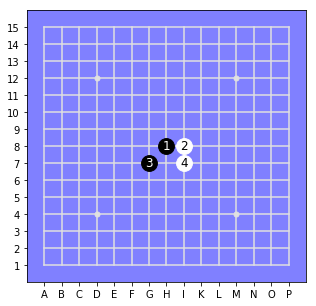

In [13]:
board = GomokuBoard(15, 5, [(H,8), (I,8), (G,7), (I,7)])
board.display();

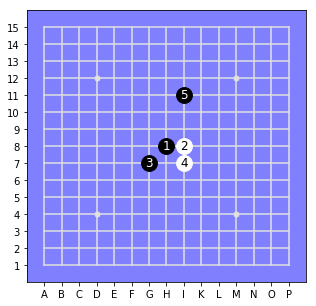

In [14]:
board.set(I,11)
board.display()

---
Now, we can ask the board to tell us what a particular field *thinks* about its neighbourhood. The field's own position is marked with an asterisk. Please observe that again those stones not sharing a common line with the point of view simply don't show up in that fields view of the neighbourhood.

In [15]:
for coords in [(H, 7)]:
    print(coords)
    print(board.getn9x9(*coords))

(8, 7)
|                 |
|                 |
|                 |
|        x o      |
|      x * o      |
|                 |
|                 |
|                 |
|                 |


---
#### Undo the last move

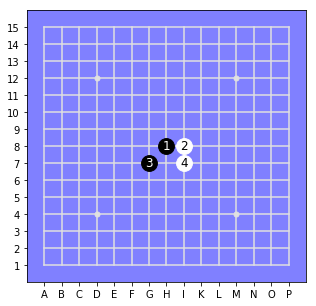

In [16]:
board.undo()
board.display()

In [17]:
for coords in [(I,9)]:
    print(coords)
    print(board.getn9x9(*coords))

(9, 9)
|                 |
|                 |
|                 |
|                 |
|        *        |
|      x o        |
|    x   o        |
|                 |
|                 |


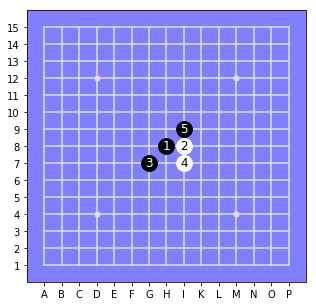

In [18]:
board.set(I, 9)
board.display()